In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt

In [2]:
class SimpleMLP(nn.Module):
    def __init__(self, activation='relu'):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 100)

        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
def initialize_weights(model, init_type=None):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            if init_type == 'xavier':
                init.xavier_normal_(m.weight)
                print(f'Xavier 초기화: {m.weight.std().item():.5f}')
            elif init_type == 'he':
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                print(f'He 초기화: {m.weight.std().item():.5f}')
            elif init_type is None:
                print(f'기본 초기화: {m.weight.std().item():.5f}')
            if m.bias is not None:
                init.zeros_(m.bias)


In [4]:
def plot_weight_distribution(model, title):
    weights = []
    for m in model.modules():
        if isinstance(m, nn.Linear):
            weights.append(m.weight.data.cpu().numpy().flatten())
    plt.figure(figsize=(10, 5))
    plt.hist(weights[0], bins=50, alpha=0.6, label="Layer 1 weights")
    plt.hist(weights[1], bins=50, alpha=0.6, label="Layer 2 weights")
    plt.title(title)
    plt.xlabel("Weight values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


## 💡 기본 초기화는 어떤 방식일까?

- `torch.nn`에서 **기본 제공하는 초기화**는 **He Initialization (Uniform 분포)** 입니다.

---

## ❓ 왜 분포가 그렇게 나왔을까?

- 하나의 노드에는 다음과 같은 형태로 값이 들어옵니다:
w1 * x1 + w2 * x2 + ... + wn * xn + b


- 즉, **입력 값(x)**이 많아질수록, 곱해지는 **가중치(w)**가 많아지므로 **총합이 커질 가능성**이 높아집니다.

- 따라서 **입력 수가 많을수록**, 분산이 커지는 걸 방지하기 위해 **더 작은 값 위주로 분포가 형성**됩니다 → 분포가 **좁아짐**.

- 반대로, **입력 수가 적은 경우**는 분포가 **넓어져야** 각 노드가 충분한 출력을 낼 수 있도록 보정합니다.

---

## ⚙️ 예시: 현재 모델 구성

```python
# Layer 1: 입력 256개 → 출력 1024개
# Layer 2: 입력 1024개 → 출력 100개


기본 초기화: 0.03606
기본 초기화: 0.01811


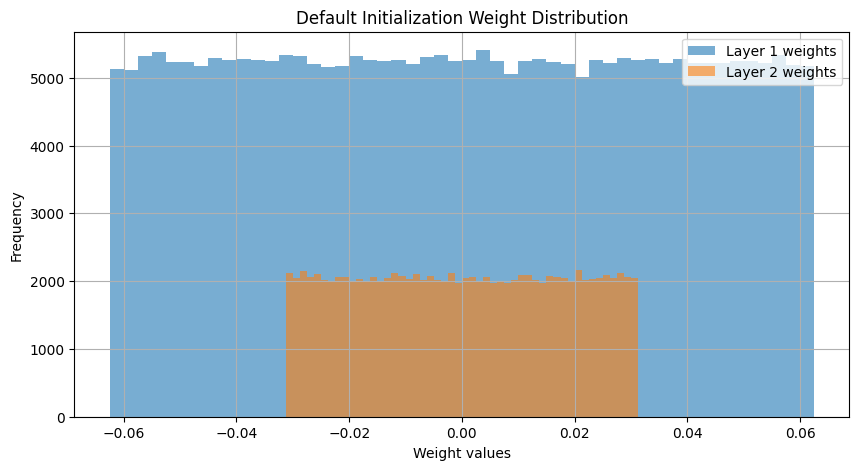

In [5]:
model_default = SimpleMLP()
initialize_weights(model_default, init_type=None)
plot_weight_distribution(model_default, "Default Initialization Weight Distribution")

Xavier

Xavier 초기화: 0.03949
Xavier 초기화: 0.04231


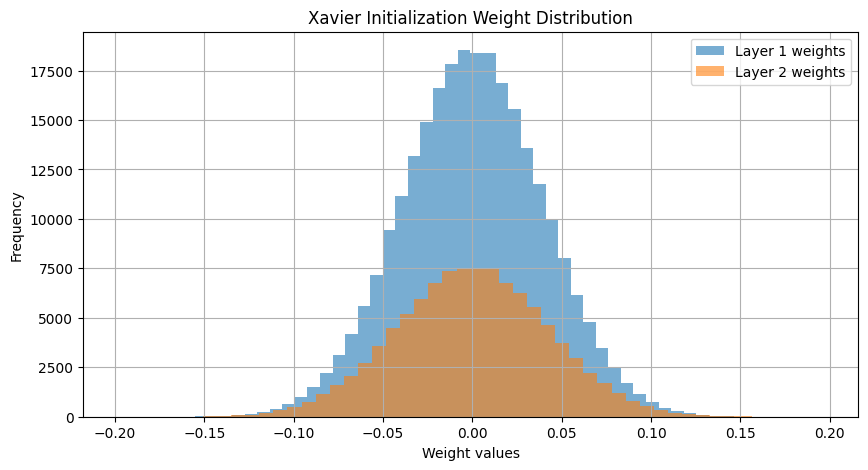

In [6]:
model_xavier = SimpleMLP()
initialize_weights(model_xavier, init_type='xavier')
plot_weight_distribution(model_xavier, 'Xavier Initialization Weight Distribution')

He 초기화: 0.08848
He 초기화: 0.04424


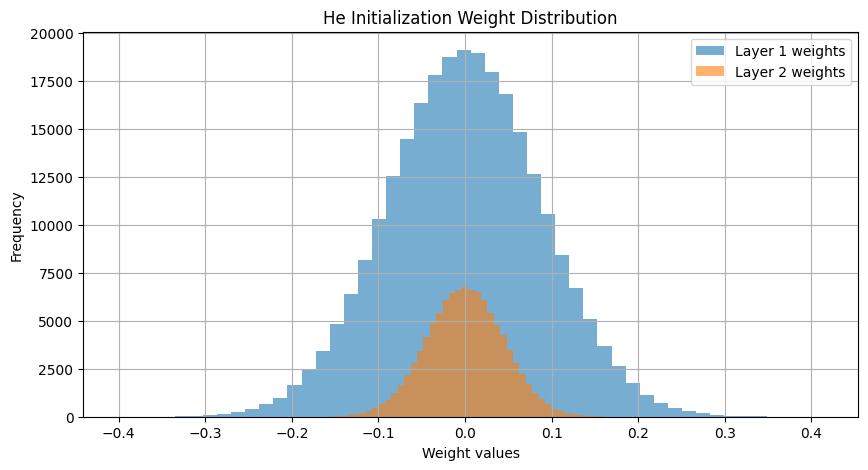

In [7]:
model_he = SimpleMLP()
initialize_weights(model_he, init_type='he')
plot_weight_distribution(model_he, 'He Initialization Weight Distribution')

# 🔍 초기화 방식과 활성화 함수 궁합 정리

## 1. 초기화 방식과 권장 활성화 함수

| 초기화 방식         | 권장 활성화 함수      |
|--------------------|------------------------|
| **Xavier (Glorot)**| `sigmoid`, `tanh`      |
| **He (Kaiming)**   | `ReLU`, `LeakyReLU`    |

---

## 2. 수식 비교

- **Xavier (Glorot) 초기화**  
  입력 노드 수와 출력 노드 수를 모두 고려하여 분산 계산:

  $$
  \text{Var}(w) = \frac{2}{\text{fan\_in} + \text{fan\_out}}
  $$

- **He (Kaiming) 초기화**  
  ReLU에 최적화되어 입력 노드 수만 고려:

  $$
  \text{Var}(w) = \frac{2}{\text{fan\_in}}
  $$

✅ 일반적으로 He 초기화는 더 큰 분산을 가짐 → **분포가 더 넓음**

---

## 3. 예시로 보는 분포 차이

```python
# Layer 구조
fc1 = nn.Linear(256, 1024)
fc2 = nn.Linear(1024, 100)


## ❓ 왜 Xavier는 Sigmoid에 적합할까?

### ✅ Sigmoid / tanh 함수의 특성

- 입력값이 **너무 크거나 작으면**, 아래와 같은 문제가 발생합니다:

  > **Gradient Vanishing Problem**  
  > → 기울기(gradient)가 **0에 가까워져 학습이 멈춤**

- 이를 방지하기 위해서는:
  - **입력값을 0 근처로 유지**해야 함
  - 즉, **weight의 초기 분포가 작고 균일**해야 함

➡️ **Xavier 초기화는** 입력 노드 수와 출력 노드 수의 평균을 기반으로 작은 분산을 제공  
➡️ 결과적으로 **Sigmoid/tanh와 잘 어울림**

---

### ✅ ReLU 함수의 특성

- ReLU는 입력이 **0 이하일 경우 출력이 0**입니다:
  
  $$
  \text{ReLU}(x) = \begin{cases} 
  x, & x > 0 \\
  0, & x \leq 0 
  \end{cases}
  $$

- 따라서 weight가 너무 작으면:
  - 많은 뉴런들이 **출력을 못 하고 죽어버림(dead neuron)**

➡️ 이를 방지하기 위해선 **더 넓은 분포**가 필요  
➡️ **He 초기화는 fan_in만 고려해 Xavier보다 큰 분산을 제공**  
➡️ **ReLU와 궁합이 좋음**

---

## 🧠 정리

| 활성화 함수 | 적합한 초기화 방식 | 이유 |
|-------------|--------------------|------|
| `sigmoid`, `tanh` | **Xavier** | 입력을 작게 유지해 gradient vanishing 방지 |
| `ReLU` 계열        | **He**     | 죽은 뉴런 방지 위해 더 큰 분산 필요 |
